In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

,Extent,Date
0,1107873.946,1979-01-01
1,1211101.473,1979-02-01
2,1215128.770,1979-03-01
3,1233940.811,1979-04-01
4,1193061.566,1979-05-01
...,...,...
533,124025.343,2023-06-01
534,53107.426,2023-07-01
535,11242.827,2023-08-01
536,3272.024,2023-09-01


In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 26s 315ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2151
Epoch 2/50
53/53 [==============================] - 16s 306ms/step - loss: 0.0993 - root_mean_squared_error: 0.3152 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 3/50
53/53 [==============================] - 18s 343ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 4/50
53/53 [==============================] - 19s 363ms/step - loss: 0.0437 - root_mean_squared_error: 0.2091 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 5/50
53/53 [==============================] - 18s 339ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1577
Epoch 6/50
53/53 [==============================] - 14s 261ms/step - loss: 0.0357 - root_mean_squared_error: 0.1890 - val_loss: 0.0222 

Epoch 27/50
53/53 [==============================] - 12s 238ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 28/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1062
Epoch 29/50
53/53 [==============================] - 12s 236ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 30/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 31/50
53/53 [==============================] - 13s 256ms/step - loss: 0.0149 - root_mean_squared_error: 0.1220 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008
Epoch 32/50
53/53 [==============================] - 13s 248ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.009

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.001788441340128 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

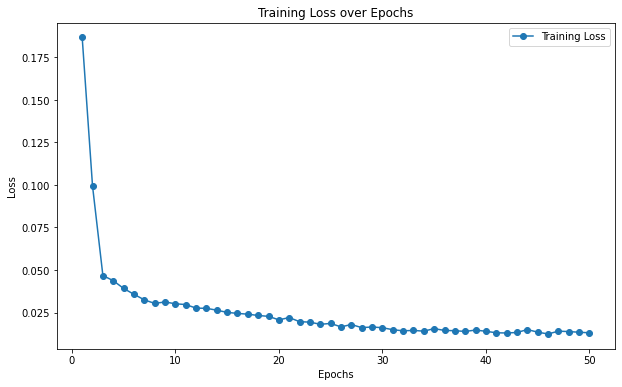

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

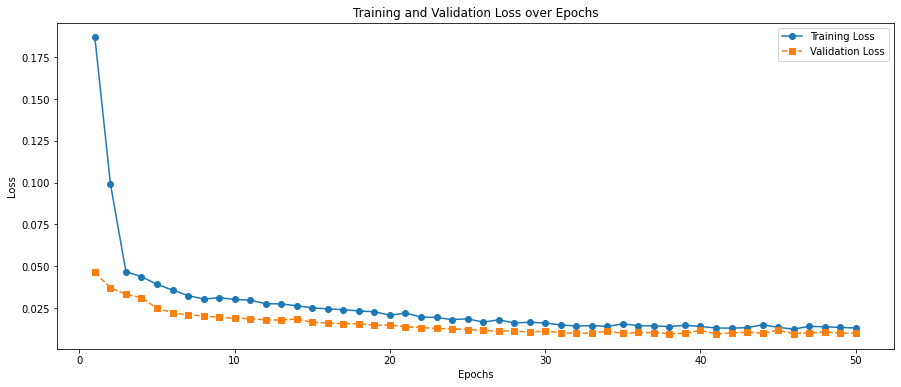

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 17ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10135437000398094
MAE : 0.08251133346899174


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,16927.382812,44787.893
1,-32754.693359,14909.156
2,-3738.490723,54595.378
3,89278.992188,242829.930
4,234726.078125,406860.687
5,397515.937500,605897.837
6,523447.656250,654073.790
7,564954.375000,701143.910
8,530549.687500,657891.340
9,433811.437500,432215.421


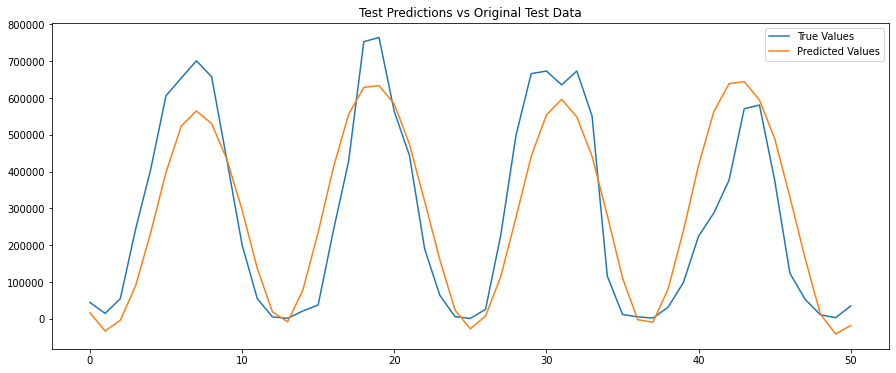

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

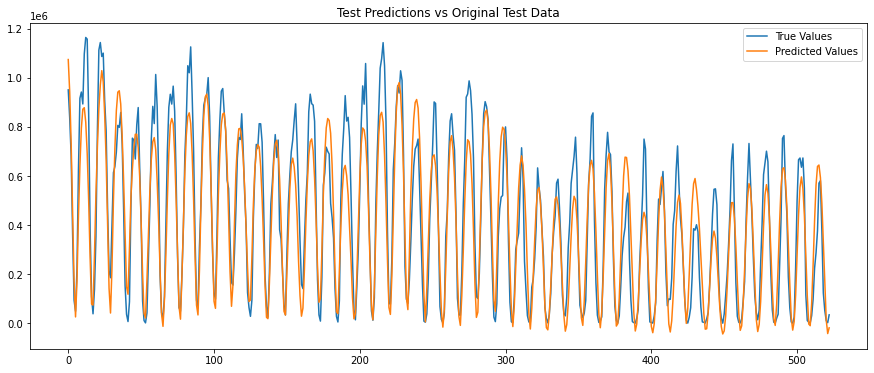

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()